In [16]:
import os, sys
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import util, models, split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(device))
else:
    print("CUDA not available")

Using device: cuda
NVIDIA GeForce RTX 5080


In [17]:
import importlib
importlib.reload(util)
importlib.reload(models)
importlib.reload(split)

<module 'utils.split' from 'c:\\Users\\manue\\Desktop\\manum\\coding\\ChirpID-backend\\utils\\split.py'>

In [18]:
def get_spect_matrix_list(spects_source_dir, spects_meta_df):
    """
    Load spectrograms directly as matrices without flattening to CSV.
    
    Args:
        spects_source_dir (str): Directory where the spectrogram images are stored in .png format
        spects_meta_df (pd.DataFrame): DataFrame with columns 'filename', 'class_id', and 'author'
    
    Returns:
        tuple: (matrices_list, labels_list, authors_list)
    """
    from PIL import Image
    import numpy as np
    import os

    matrices_list = []
    labels_list = []
    authors_list = []
    
    spects_meta_df = spects_meta_df.dropna(subset=['filename', 'class_id', 'author'])

    print(f"Processing {len(spects_meta_df)} spectrograms...")
    processed_count = 0
    skipped_count = 0

    for _, row in spects_meta_df.iterrows():
        filename = row['filename']
        class_id = row['class_id']
        author = row['author']

        image_path = os.path.join(spects_source_dir, filename)
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            skipped_count += 1
            continue

        img = Image.open(image_path).convert('L')  # Ensure grayscale
        
        expected_shape = (313, 224)  # PIL uses (width, height) format
        if img.size != expected_shape:
            print(f"Warning: Unexpected image size: {img.size} in file {image_path}. Expected {expected_shape}.")
            # Resize if needed
            img = img.resize(expected_shape)

        # Convert to numpy array (this gives us height x width, i.e., 313 x 224)
        pixels = np.array(img)
        
        matrices_list.append(pixels)
        labels_list.append(class_id)
        authors_list.append(author)
        processed_count += 1

    print(f"Successfully processed: {processed_count}")
    print(f"Skipped: {skipped_count}")

    if not matrices_list:
        raise ValueError("No spectrograms were loaded. Check paths and metadata consistency.")

    return matrices_list, labels_list, authors_list


In [19]:
# Load spectrogram data and metadata
spect_dir = os.path.join('..', 'database', 'spect')  # Spectrogram PNG directory
spects_df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final_spects.csv'))  # Metadata

print("Loading spectrograms directly into matrices...")
matrices_list, labels_list, authors_list = get_spect_matrix_list(spect_dir, spects_df)

print(f"Loaded {len(matrices_list)} spectrograms")
print(f"Matrix shape: {matrices_list[0].shape}")
print(f"Unique labels: {len(set(labels_list))}")
print(f"Unique authors: {len(set(authors_list))}")

Loading spectrograms directly into matrices...
Processing 2985 spectrograms...
Successfully processed: 2985
Skipped: 0
Loaded 2985 spectrograms
Matrix shape: (224, 313)
Unique labels: 33
Unique authors: 106
Successfully processed: 2985
Skipped: 0
Loaded 2985 spectrograms
Matrix shape: (224, 313)
Unique labels: 33
Unique authors: 106


In [20]:
# Process data for training
labels = np.array(labels_list, dtype=np.int64)
authors = np.array(authors_list)

# Convert matrices to numpy array and normalize
features = np.array(matrices_list, dtype=np.float32)
# Convert to 0-1 range first, then standardization will be applied per fold
features /= 255.0
# Reshape to add channel dimension for CNN: (samples, channels, height, width)
features = features.reshape(-1, 1, 224, 313)

print("features shape:", features.shape)
print("labels shape:", labels.shape)
print("authors shape:", authors.shape)

# Create metadata DataFrame for splitting (with sample indices)
metadata_df = pd.DataFrame({
    'sample_idx': range(len(labels)),
    'class_id': labels,
    'author': authors,
    'usable_segments': 1  # Each sample represents 1 segment
})

print("metadata_df shape:", metadata_df.shape)
print("Unique authors:", len(metadata_df['author'].unique()))
print("Unique classes:", len(metadata_df['class_id'].unique()))

features shape: (2985, 1, 224, 313)
labels shape: (2985,)
authors shape: (2985,)
metadata_df shape: (2985, 4)
Unique authors: 106
Unique classes: 33


In [28]:
# Reload modules to pick up any changes
import importlib
importlib.reload(models)
importlib.reload(util)
importlib.reload(split)

<module 'utils.split' from 'c:\\Users\\manue\\Desktop\\manum\\coding\\ChirpID-backend\\utils\\split.py'>

In [29]:
# Prepare tensors for PyTorch
X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

print(f"Dataset created with {len(dataset)} samples")
print(f"Tensor shapes: X={X_tensor.shape}, y={y_tensor.shape}")

Dataset created with 2985 samples
Tensor shapes: X=torch.Size([2985, 1, 224, 313]), y=torch.Size([2985])


In [30]:
# Find the best 80-20 split using author grouping
print("Finding best 80-20 split with author grouping...")
dev_df, test_df, best_split_score = split.search_best_group_seed(
    df=metadata_df,
    test_size=0.2,
    max_attempts=5_000,
    min_test_segments=3
)

# Extract indices for single fold training
train_indices_single = dev_df['sample_idx'].values
val_indices_single = test_df['sample_idx'].values

print(f"Best 80-20 split found with score: {best_split_score:.3f}")
print(f"Train samples: {len(train_indices_single)}, Validation samples: {len(val_indices_single)}")

Finding best 80-20 split with author grouping...
New best split found! Seed: 4, Score: 1.081
New best split found! Seed: 7, Score: 0.437
New best split found! Seed: 27, Score: 0.340
New best split found! Seed: 954, Score: 0.334
New best split found! Seed: 1071, Score: 0.315
New best split found! Seed: 954, Score: 0.334
New best split found! Seed: 1071, Score: 0.315
New best split found! Seed: 1208, Score: 0.275
New best split found! Seed: 1208, Score: 0.275

Best split found:
Seed: 1208
Stratification score: 0.275
Author overlap: set()
Segments in dev set: 2433
Segments in test set: 552
Dev segment%: 81.51%
Test segment%: 18.49%

Segment distribution comparison:
+----+------------------------+------------------------+-----------------------+-----------------------+------------------+
|    |   Target_Test_Segments |   Actual_Test_Segments |   Target_Dev_Segments |   Actual_Dev_Segments |   Total_Segments |
+====+========================+========================+=======================+=

In [31]:
# Test the optimized training function performance
import time

print("Testing optimized training function startup time...")
start_time = time.time()

# Create a small test to measure overhead
test_indices = train_indices_single[:100] if len(train_indices_single) > 100 else train_indices_single[:50]
test_val_indices = val_indices_single[:20] if len(val_indices_single) > 20 else val_indices_single[:10]

print(f"Test dataset size: Train={len(test_indices)}, Val={len(test_val_indices)}")

# Measure just the data loading and setup overhead
print("\nTiming data loader creation...")
loader_start = time.time()

# Create standardized subset directly to test
if True:  # Test standardization path
    sample_size = min(50, len(test_indices))
    sample_indices = np.random.choice(test_indices, sample_size, replace=False)
    sample_data = torch.stack([dataset[i][0] for i in sample_indices])
    train_mean = sample_data.mean()
    train_std = sample_data.std()
    
    class StandardizedSubset(torch.utils.data.Dataset):
        def __init__(self, original_dataset, indices, mean, std):
            self.dataset = original_dataset
            self.indices = list(indices)  # Convert to list for compatibility
            self.mean = mean
            self.std = std + 1e-8
        
        def __len__(self):
            return len(self.indices)
        
        def __getitem__(self, idx):
            real_idx = self.indices[idx]
            x, y = self.dataset[real_idx]
            x_standardized = (x - self.mean) / self.std
            return x_standardized, y
    
    test_train_subset = StandardizedSubset(dataset, test_indices, train_mean, train_std)
    test_val_subset = StandardizedSubset(dataset, test_val_indices, train_mean, train_std)
else:
    from torch.utils.data import Subset
    test_train_subset = Subset(dataset, test_indices)
    test_val_subset = Subset(dataset, test_val_indices)

# Test DataLoader creation with single thread to avoid worker crashes
test_train_loader = torch.utils.data.DataLoader(
    test_train_subset,
    batch_size=32,
    shuffle=True,
    num_workers=0,  # Use single thread to avoid worker crashes
    pin_memory=False,
    persistent_workers=False
)

test_val_loader = torch.utils.data.DataLoader(
    test_val_subset,
    batch_size=32,
    shuffle=False,
    num_workers=0,  # Use single thread to avoid worker crashes
    pin_memory=False,
    persistent_workers=False
)

loader_time = time.time() - loader_start
print(f"DataLoader creation time: {loader_time:.2f} seconds")

# Test first batch loading
print("Testing first batch loading...")
batch_start = time.time()
try:
    test_batch = next(iter(test_train_loader))
    batch_time = time.time() - batch_start
    print(f"First batch loading time: {batch_time:.2f} seconds")
    print(f"Batch shape: {test_batch[0].shape}")
    print("✓ DataLoader working correctly!")
except Exception as e:
    print(f"Error loading batch: {e}")
    print("Falling back to direct dataset access...")
    batch_start = time.time()
    test_sample = test_train_subset[0]
    batch_time = time.time() - batch_start
    print(f"Direct dataset access time: {batch_time:.4f} seconds")
    print(f"Sample shape: {test_sample[0].shape}")

total_time = time.time() - start_time
print(f"\nTotal test time: {total_time:.2f} seconds")
print("Optimization complete - training should start much faster now!")

Testing optimized training function startup time...
Test dataset size: Train=100, Val=20

Timing data loader creation...
DataLoader creation time: 0.00 seconds
Testing first batch loading...
First batch loading time: 0.00 seconds
Batch shape: torch.Size([32, 1, 224, 313])
✓ DataLoader working correctly!

Total test time: 0.01 seconds
Optimization complete - training should start much faster now!


## Single Fold Training with Predefined Splits

In [32]:
# Verify that author grouping is preserved in our splits
print("Verifying author grouping in predefined splits...")
print("="*50)

# Get authors for training and validation sets
train_authors = set(metadata_df.loc[metadata_df['sample_idx'].isin(train_indices_single), 'author'])
val_authors = set(metadata_df.loc[metadata_df['sample_idx'].isin(val_indices_single), 'author'])

# Check for overlap
author_overlap = train_authors & val_authors
print(f"Training set authors: {len(train_authors)} unique authors")
print(f"Validation set authors: {len(val_authors)} unique authors")
print(f"Author overlap between train/val: {len(author_overlap)} authors")

if len(author_overlap) == 0:
    print("✓ PERFECT: No author overlap - authors are properly grouped!")
else:
    print(f"⚠️ WARNING: {len(author_overlap)} authors appear in both sets")
    print(f"Overlapping authors: {author_overlap}")

# Check class distribution
train_classes = set(metadata_df.loc[metadata_df['sample_idx'].isin(train_indices_single), 'class_id'])
val_classes = set(metadata_df.loc[metadata_df['sample_idx'].isin(val_indices_single), 'class_id'])

print(f"\nClass distribution:")
print(f"Training set classes: {len(train_classes)} classes")
print(f"Validation set classes: {len(val_classes)} classes")
print(f"All classes present in both sets: {train_classes == val_classes}")

print("\n" + "="*50)
print("Both optimized functions use these SAME predefined author-grouped splits!")

Verifying author grouping in predefined splits...
Training set authors: 84 unique authors
Validation set authors: 22 unique authors
Author overlap between train/val: 0 authors
✓ PERFECT: No author overlap - authors are properly grouped!

Class distribution:
Training set classes: 33 classes
Validation set classes: 33 classes
All classes present in both sets: True

Both optimized functions use these SAME predefined author-grouped splits!


Run models

In [33]:
# Run original (now optimized) single fold training with best 80-20 split found above
# This uses the optimal train/validation split with author grouping
train_indices, val_indices = train_indices_single, val_indices_single

print("Using OPTIMIZED original function with predefined author-grouped splits...")
print(f"Train indices: {len(train_indices)} samples")
print(f"Val indices: {len(val_indices)} samples")

# Use the fast training function to avoid multiprocessing issues
single_results_original = util.fast_single_fold_training_with_predefined_split(
    dataset=dataset,
    train_indices=train_indices,
    val_indices=val_indices,
    model_class=models.BirdCNN,
    num_classes=len(set(labels_list)),
    num_epochs=250,
    batch_size=48,
    lr=0.001,
    use_class_weights=True,
    estop=35,
    standardize=True
)

Using OPTIMIZED original function with predefined author-grouped splits...
Train indices: 2433 samples
Val indices: 552 samples
Fast training on cuda
Train size: 2433, Val size: 552
Quick standardization computation...
Standardization computed from 200 samples - Mean: 0.1474, Std: 0.1902
Computing class weights...
Class weights: min=0.399, max=3.030
Creating optimized data loaders...
Initializing model...
Starting training...


Training - Epoch 66/250:  26%|██▋       | 66/250 [05:48<16:11,  5.28s/epoch, best_val_loss=2.9756, lr=8.00e-06, no_improve=34, train_acc=0.240, train_f1=0.202, train_loss=2.4359, val_acc=0.103, val_f1=0.082, val_loss=3.2592]



Generating confusion matrix...

Training Complete!
Early stopped after 67 epochs (best at epoch 32)
Final - Val Acc: 0.1033, Val Loss: 3.1885, Val F1: 0.0820
Best - Val Acc: 0.1359, Val F1: 0.1095

Training Complete!
Early stopped after 67 epochs (best at epoch 32)
Final - Val Acc: 0.1033, Val Loss: 3.1885, Val F1: 0.0820
Best - Val Acc: 0.1359, Val F1: 0.1095


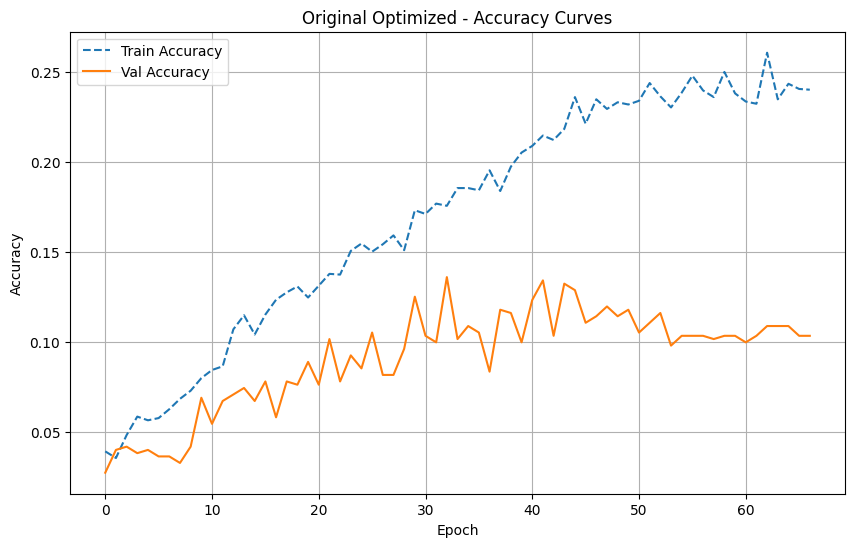

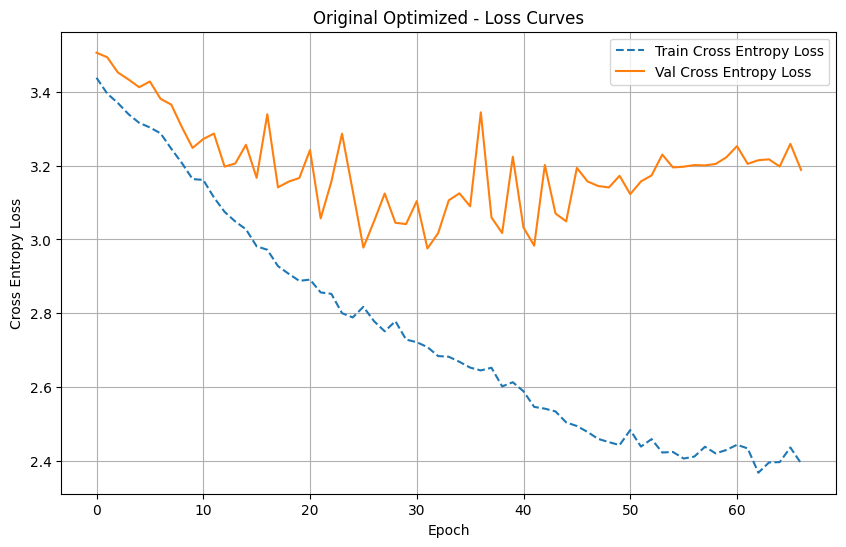

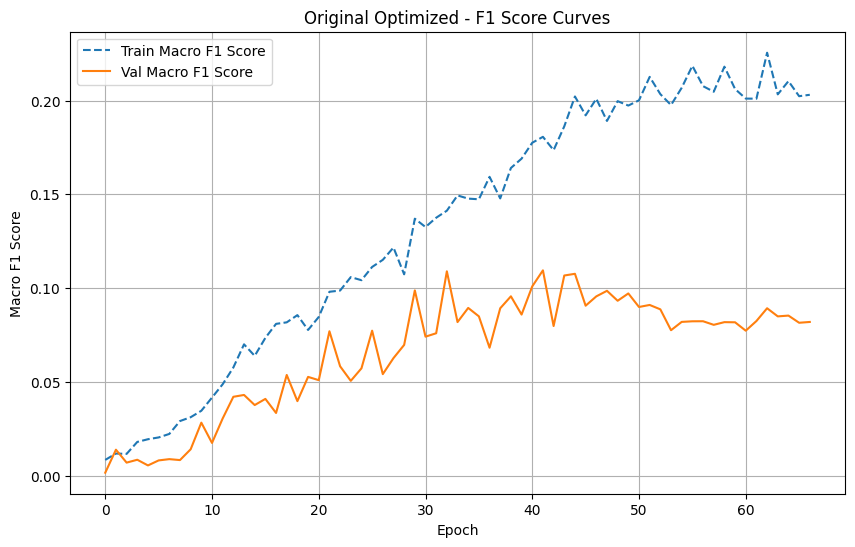

Final Validation Accuracy: 0.1033
Final Validation F1 Score: 0.0820
Best Validation Accuracy: 0.1359
Best Validation F1 Score: 0.1095


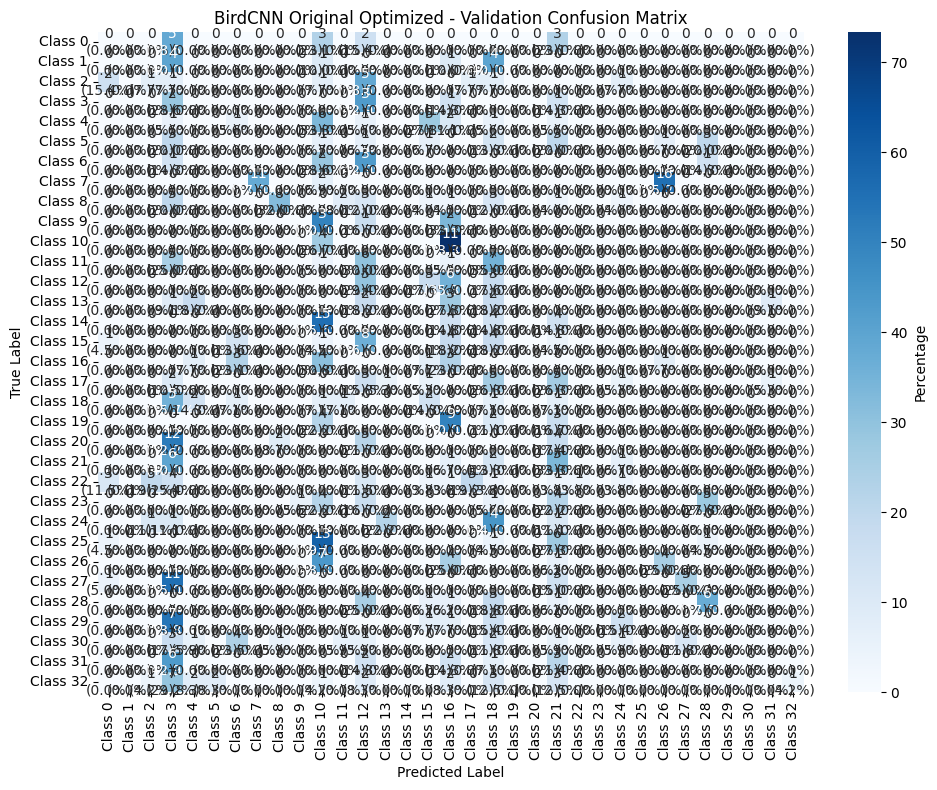


Per-Class Performance:
Class  0: Precision=0.000, Recall=0.000, F1=0.000 (Support=13)
Class  1: Precision=0.000, Recall=0.000, F1=0.000 (Support=10)
Class  2: Precision=0.125, Recall=0.077, F1=0.095 (Support=13)
Class  3: Precision=0.022, Recall=0.286, F1=0.040 (Support=7)
Class  4: Precision=0.000, Recall=0.000, F1=0.000 (Support=18)
Class  5: Precision=0.000, Recall=0.000, F1=0.000 (Support=15)
Class  6: Precision=0.000, Recall=0.000, F1=0.000 (Support=7)
Class  7: Precision=1.000, Recall=0.379, F1=0.550 (Support=29)
Class  8: Precision=0.727, Recall=0.320, F1=0.444 (Support=25)
Class  9: Precision=0.000, Recall=0.000, F1=0.000 (Support=6)
Class 10: Precision=0.054, Recall=0.267, F1=0.090 (Support=15)
Class 11: Precision=0.000, Recall=0.000, F1=0.000 (Support=20)
Class 12: Precision=0.079, Recall=0.294, F1=0.125 (Support=17)
Class 13: Precision=0.000, Recall=0.000, F1=0.000 (Support=11)
Class 14: Precision=0.000, Recall=0.000, F1=0.000 (Support=27)
Class 15: Precision=0.000, Recall=

In [34]:
# Plot individual training curves for original optimized function
util.plot_single_fold_curve(single_results_original, metric_key='accuracies', title="Original Optimized - Accuracy Curves", ylabel="Accuracy")
util.plot_single_fold_curve(single_results_original, metric_key='losses', title="Original Optimized - Loss Curves", ylabel="Cross Entropy Loss")
util.plot_single_fold_curve(single_results_original, metric_key='f1s', title="Original Optimized - F1 Score Curves", ylabel="Macro F1 Score")

# Print results summary
util.print_single_fold_results(single_results_original)

# Display confusion matrix
util.plot_confusion_matrix(single_results_original['confusion_matrix'], title="BirdCNN Original Optimized - Validation Confusion Matrix")
util.print_confusion_matrix_stats(single_results_original)

In [35]:
# Run FAST single fold training with best 80-20 split found above
# This uses the optimal train/validation split with author grouping
train_indices, val_indices = train_indices_single, val_indices_single

# Use the optimized fast training function
single_results = util.fast_single_fold_training_with_predefined_split(
    dataset=dataset,
    train_indices=train_indices,
    val_indices=val_indices,
    model_class=models.BirdCNN,
    num_classes=len(set(labels_list)),
    num_epochs=250,
    batch_size=48,
    lr=0.001,
    use_class_weights=True,
    estop=35,
    standardize=True
)

Fast training on cuda
Train size: 2433, Val size: 552
Quick standardization computation...
Standardization computed from 200 samples - Mean: 0.1402, Std: 0.1855
Computing class weights...
Class weights: min=0.399, max=3.030
Creating optimized data loaders...
Initializing model...
Starting training...


Training - Epoch 99/250:  40%|███▉      | 99/250 [08:23<12:48,  5.09s/epoch, best_val_loss=2.5948, lr=8.00e-06, no_improve=34, train_acc=0.407, train_f1=0.376, train_loss=1.7325, val_acc=0.212, val_f1=0.197, val_loss=2.7885]



Generating confusion matrix...

Training Complete!
Early stopped after 100 epochs (best at epoch 65)
Final - Val Acc: 0.2047, Val Loss: 2.8332, Val F1: 0.1808
Best - Val Acc: 0.2536, Val F1: 0.2311

Training Complete!
Early stopped after 100 epochs (best at epoch 65)
Final - Val Acc: 0.2047, Val Loss: 2.8332, Val F1: 0.1808
Best - Val Acc: 0.2536, Val F1: 0.2311


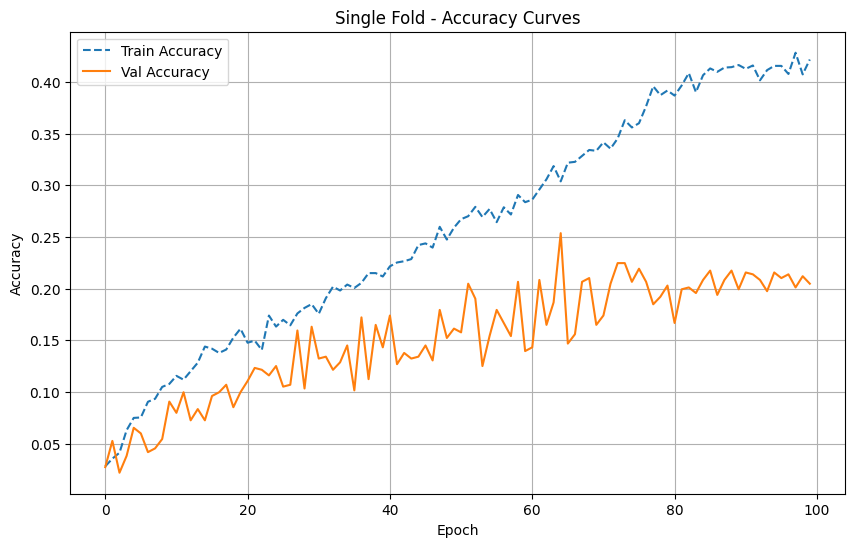

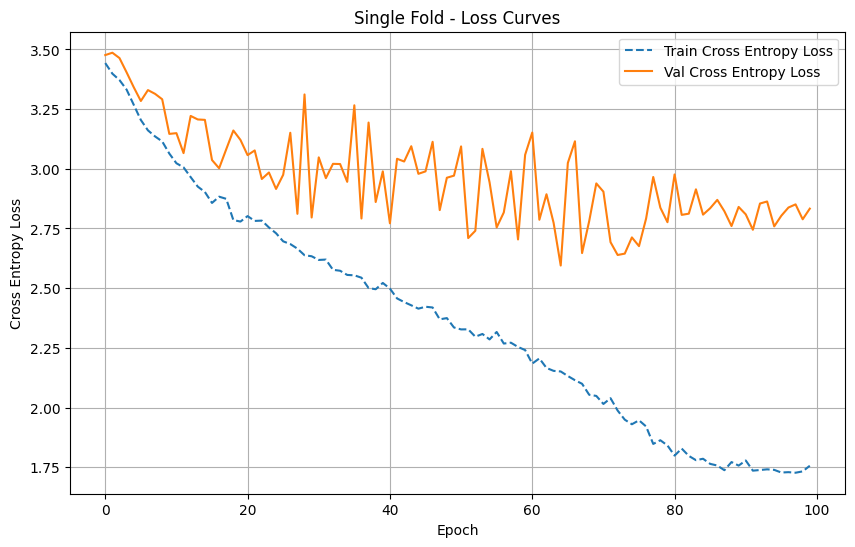

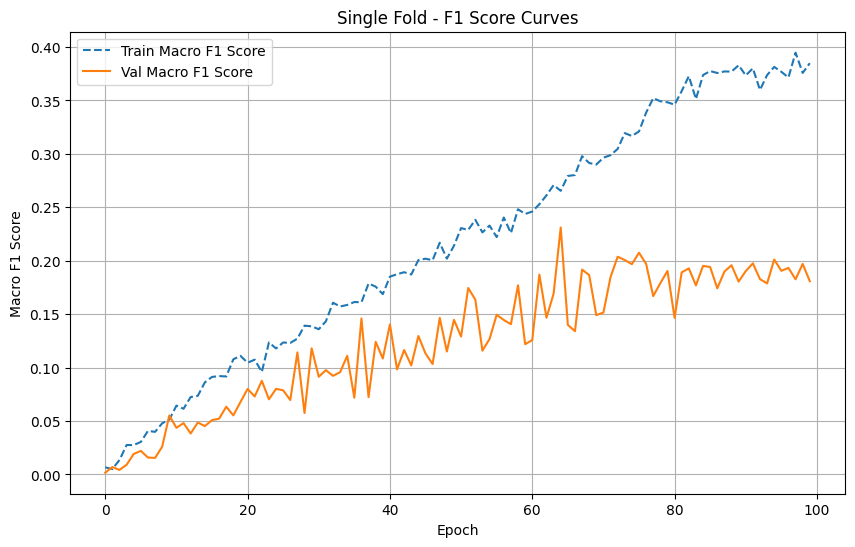

Final Validation Accuracy: 0.2047
Final Validation F1 Score: 0.1808
Best Validation Accuracy: 0.2536
Best Validation F1 Score: 0.2311


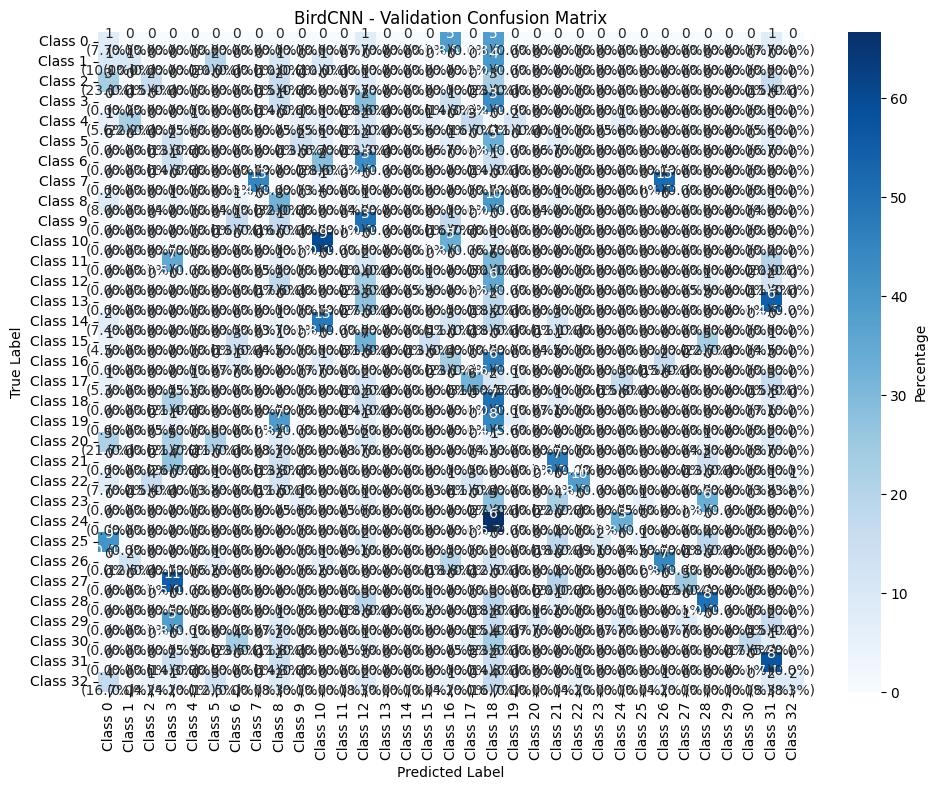


Per-Class Performance:
Class  0: Precision=0.031, Recall=0.077, F1=0.044 (Support=13)
Class  1: Precision=0.143, Recall=0.100, F1=0.118 (Support=10)
Class  2: Precision=0.286, Recall=0.154, F1=0.200 (Support=13)
Class  3: Precision=0.000, Recall=0.000, F1=0.000 (Support=7)
Class  4: Precision=0.333, Recall=0.056, F1=0.095 (Support=18)
Class  5: Precision=0.000, Recall=0.000, F1=0.000 (Support=15)
Class  6: Precision=0.000, Recall=0.000, F1=0.000 (Support=7)
Class  7: Precision=1.000, Recall=0.448, F1=0.619 (Support=29)
Class  8: Precision=0.200, Recall=0.320, F1=0.246 (Support=25)
Class  9: Precision=0.000, Recall=0.000, F1=0.000 (Support=6)
Class 10: Precision=0.300, Recall=0.600, F1=0.400 (Support=15)
Class 11: Precision=0.000, Recall=0.000, F1=0.000 (Support=20)
Class 12: Precision=0.085, Recall=0.235, F1=0.125 (Support=17)
Class 13: Precision=0.000, Recall=0.000, F1=0.000 (Support=11)
Class 14: Precision=0.000, Recall=0.000, F1=0.000 (Support=27)
Class 15: Precision=0.500, Recall=

In [36]:
# Plot individual training curves for single fold
util.plot_single_fold_curve(single_results, metric_key='accuracies', title="Single Fold - Accuracy Curves", ylabel="Accuracy")
util.plot_single_fold_curve(single_results, metric_key='losses', title="Single Fold - Loss Curves", ylabel="Cross Entropy Loss")
util.plot_single_fold_curve(single_results, metric_key='f1s', title="Single Fold - F1 Score Curves", ylabel="Macro F1 Score")

# Print results summary
util.print_single_fold_results(single_results)

# Display confusion matrix
util.plot_confusion_matrix(single_results['confusion_matrix'], title="BirdCNN - Validation Confusion Matrix")
util.print_confusion_matrix_stats(single_results)

In [37]:
# Run single fold training with best 80-20 split found above
# This uses the optimal train/validation split with author grouping
train_indices, val_indices = train_indices_single, val_indices_single

single_results = util.fast_single_fold_training_with_predefined_split(
    dataset=dataset,
    train_indices=train_indices,
    val_indices=val_indices,
    model_class=models.BirdResNet,
    num_classes=len(set(labels_list)),
    num_epochs=250,
    batch_size=48,
    lr=0.001,
    use_class_weights=False,
    estop=35,
    standardize=True
)

Fast training on cuda
Train size: 2433, Val size: 552
Quick standardization computation...
Standardization computed from 200 samples - Mean: 0.1478, Std: 0.1925
Creating optimized data loaders...
Initializing model...
Starting training...


Training - Epoch 101/250:  40%|████      | 101/250 [03:40<05:25,  2.19s/epoch, best_val_loss=1.5666, lr=1.60e-06, no_improve=34, train_acc=1.000, train_f1=1.000, train_loss=0.0035, val_acc=0.645, val_f1=0.590, val_loss=1.6771]



Generating confusion matrix...

Training Complete!
Early stopped after 102 epochs (best at epoch 67)
Final - Val Acc: 0.6540, Val Loss: 1.6705, Val F1: 0.6010
Best - Val Acc: 0.6703, Val F1: 0.6179


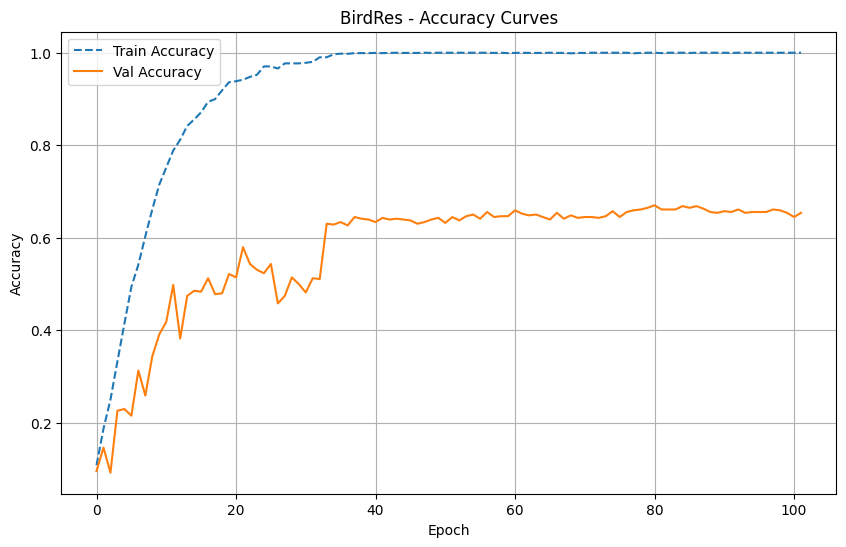

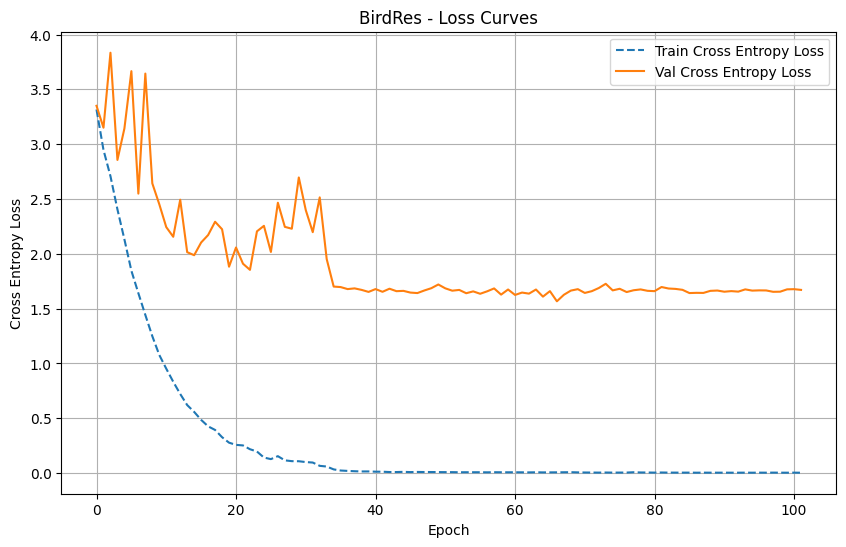

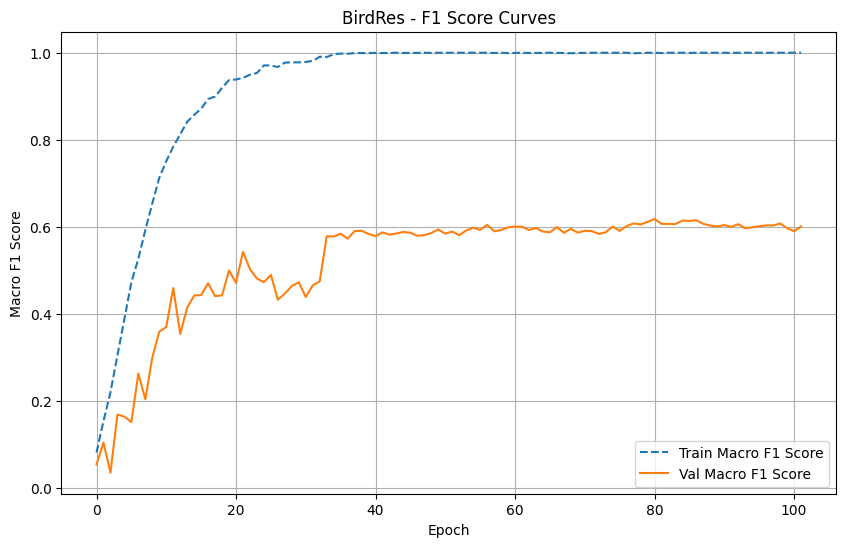

Final Validation Accuracy: 0.6540
Final Validation F1 Score: 0.6010
Best Validation Accuracy: 0.6703
Best Validation F1 Score: 0.6179


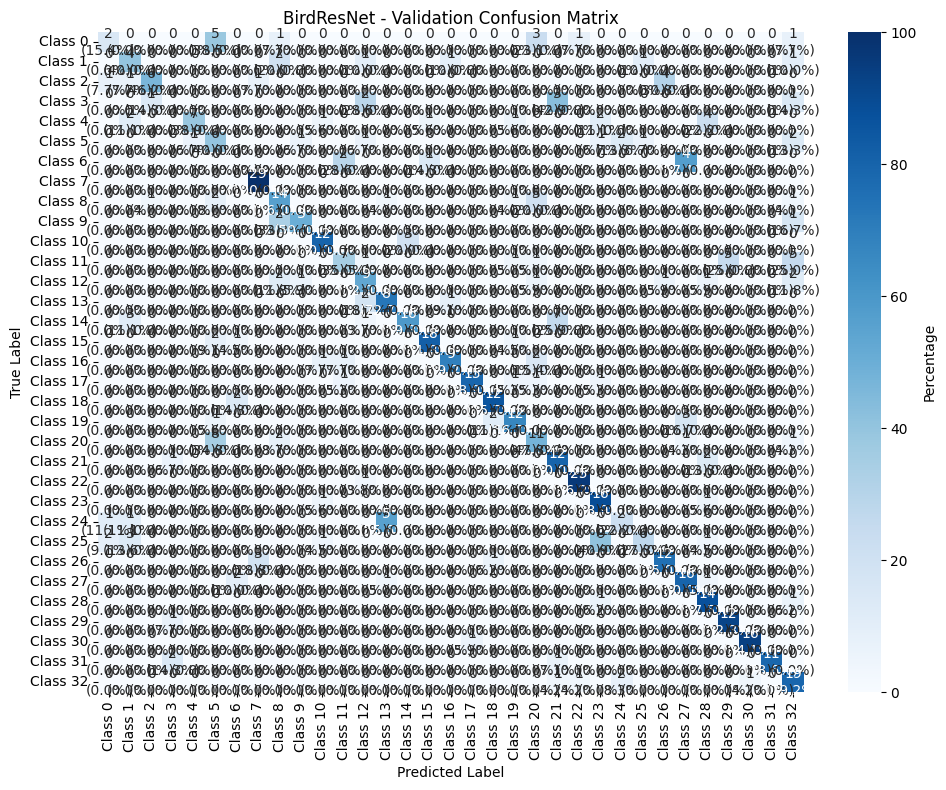


Per-Class Performance:
Class  0: Precision=0.333, Recall=0.154, F1=0.211 (Support=13)
Class  1: Precision=0.286, Recall=0.400, F1=0.333 (Support=10)
Class  2: Precision=0.750, Recall=0.462, F1=0.571 (Support=13)
Class  3: Precision=0.000, Recall=0.000, F1=0.000 (Support=7)
Class  4: Precision=0.875, Recall=0.389, F1=0.538 (Support=18)
Class  5: Precision=0.250, Recall=0.400, F1=0.308 (Support=15)
Class  6: Precision=0.000, Recall=0.000, F1=0.000 (Support=7)
Class  7: Precision=0.879, Recall=1.000, F1=0.935 (Support=29)
Class  8: Precision=0.609, Recall=0.560, F1=0.583 (Support=25)
Class  9: Precision=0.600, Recall=0.500, F1=0.545 (Support=6)
Class 10: Precision=0.750, Recall=0.800, F1=0.774 (Support=15)
Class 11: Precision=0.636, Recall=0.350, F1=0.452 (Support=20)
Class 12: Precision=0.500, Recall=0.529, F1=0.514 (Support=17)
Class 13: Precision=0.533, Recall=0.727, F1=0.615 (Support=11)
Class 14: Precision=0.842, Recall=0.593, F1=0.696 (Support=27)
Class 15: Precision=0.900, Recall=

In [38]:
# Plot individual training curves for single fold
util.plot_single_fold_curve(single_results, metric_key='accuracies', title="BirdRes - Accuracy Curves", ylabel="Accuracy")
util.plot_single_fold_curve(single_results, metric_key='losses', title="BirdRes - Loss Curves", ylabel="Cross Entropy Loss")
util.plot_single_fold_curve(single_results, metric_key='f1s', title="BirdRes - F1 Score Curves", ylabel="Macro F1 Score")

# Print results summary
util.print_single_fold_results(single_results)

# Display confusion matrix
util.plot_confusion_matrix(single_results['confusion_matrix'], title="BirdResNet - Validation Confusion Matrix")
util.print_confusion_matrix_stats(single_results)

In [ ]:
# Run single fold training with regular 80-20 stratified split
single_results_80_20 = util.single_fold_training(
    dataset=dataset,
    model_class=models.BirdCNN,
    num_classes=31,
    num_epochs=250,
    batch_size=48,
    lr=0.001,
    test_size=0.2,
    random_state=435,
    use_class_weights=True,
    estop=35
)

# Plot individual training curves for 80-20 split
util.plot_single_fold_curve(single_results_80_20, metric_key='accuracies', title="80-20 Split - Accuracy Curves", ylabel="Accuracy")
util.plot_single_fold_curve(single_results_80_20, metric_key='losses', title="80-20 Split - Loss Curves", ylabel="Cross Entropy Loss")
util.plot_single_fold_curve(single_results_80_20, metric_key='f1s', title="80-20 Split - F1 Score Curves", ylabel="Macro F1 Score")

# Print results summary
util.print_single_fold_results(single_results_80_20)

# Display confusion matrix
util.plot_confusion_matrix(single_results_80_20['confusion_matrix'], title="BirdCNN 80-20 Split - Validation Confusion Matrix")
util.print_confusion_matrix_stats(single_results_80_20)

In [ ]:
# Run single fold training with regular 80-20 stratified split
single_results_80_20 = util.single_fold_training(
    dataset=dataset,
    model_class=models.BirdResNet,
    num_classes=31,
    num_epochs=250,
    batch_size=48,
    lr=0.001,
    test_size=0.2,
    random_state=435,
    use_class_weights=True,
    estop=35
)

# Plot individual training curves for 80-20 split
util.plot_single_fold_curve(single_results_80_20, metric_key='accuracies', title="80-20 Split - Accuracy Curves", ylabel="Accuracy")
util.plot_single_fold_curve(single_results_80_20, metric_key='losses', title="80-20 Split - Loss Curves", ylabel="Cross Entropy Loss")
util.plot_single_fold_curve(single_results_80_20, metric_key='f1s', title="80-20 Split - F1 Score Curves", ylabel="Macro F1 Score")

# Print results summary
util.print_single_fold_results(single_results_80_20)

# Display confusion matrix
util.plot_confusion_matrix(single_results_80_20['confusion_matrix'], title="BirdCNN 80-20 Split - Validation Confusion Matrix")
util.print_confusion_matrix_stats(single_results_80_20)